마지막 출력층 (출력노드의수 = 1000) 바로 직전의 층 (avg_pool)의 출력값을 <br>
각 이미지의 feature 정보로 사용 <br><br>
avg_pool층이 출력하는 값의 수 = 2048 <br>
각 이미지의 특성을 2048의 변수로 표현<br><br>
2048개의 feature 정보를 사용하여 분류 알고리즘(classifier) 적용

In [21]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from matplotlib.pyplot import imshow
import math
import numpy as np
from glob import glob

산, 바다 이미지 입력 처리

In [22]:
IMG_CHANNELS = 3
IMG_ROWS = 299  # Inception 모델을 위해 크기 조정
IMG_COLS = 299  # Inception 모델을 위해 크기 조정
CLASSES = 2  # 산, 바다

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')


In [24]:
# 파일 경로에 지정, 이미지 로드
mountain_files = glob('data/imgs/data_mw/man/*jpg')
sea_files = glob('data/imgs/data_mw/woman/*jpg')

In [34]:
# 이미지와 라벨을 불러오는 함수 정의
def load_images_and_labels(files, label):
    images = [image.load_img(p, target_size=(IMG_ROWS, IMG_COLS)) for p in files]  # warping
    labels = [label] * len(files)
    print(files)
    return images, labels



In [35]:
# 산과 바다 이미지 및 라벨 불러오기
mountain_images, mountain_labels = load_images_and_labels(mountain_files, 0)
sea_images, sea_labels = load_images_and_labels(sea_files, 1)

['data/imgs/data_mw/man\\ma_1.jpg', 'data/imgs/data_mw/man\\ma_10.jpg', 'data/imgs/data_mw/man\\ma_100.jpg', 'data/imgs/data_mw/man\\ma_101.jpg', 'data/imgs/data_mw/man\\ma_102.jpg', 'data/imgs/data_mw/man\\ma_103.jpg', 'data/imgs/data_mw/man\\ma_104.jpg', 'data/imgs/data_mw/man\\ma_105.jpg', 'data/imgs/data_mw/man\\ma_106.jpg', 'data/imgs/data_mw/man\\ma_107.jpg', 'data/imgs/data_mw/man\\ma_108.jpg', 'data/imgs/data_mw/man\\ma_109.jpg', 'data/imgs/data_mw/man\\ma_11.jpg', 'data/imgs/data_mw/man\\ma_110.jpg', 'data/imgs/data_mw/man\\ma_111.jpg', 'data/imgs/data_mw/man\\ma_113.jpg', 'data/imgs/data_mw/man\\ma_114.jpg', 'data/imgs/data_mw/man\\ma_115.jpg', 'data/imgs/data_mw/man\\ma_116.jpg', 'data/imgs/data_mw/man\\ma_117.jpg', 'data/imgs/data_mw/man\\ma_118.jpg', 'data/imgs/data_mw/man\\ma_119.jpg', 'data/imgs/data_mw/man\\ma_12.jpg', 'data/imgs/data_mw/man\\ma_121.jpg', 'data/imgs/data_mw/man\\ma_122.jpg', 'data/imgs/data_mw/man\\ma_123.jpg', 'data/imgs/data_mw/man\\ma_124.jpg', 'data

In [27]:
# 이미지와 라벨 병합 및 벡터화
images = mountain_images + sea_images
labels = mountain_labels + sea_labels
vector = np.asarray([image.img_to_array(img) for img in images])

In [28]:
vector.shape

(337, 299, 299, 3)

사전학습 모델 - InceptionNet (version3) 호출

In [29]:
# 사전학습모델 - InceptionNet 로드
base_model = InceptionV3(weights='imagenet', include_top=True)

In [30]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

합성곱층 (convolutional layers) 부분에서 출력하는 feature 정보를 추출<br>
Model 클래스를 이용, 입력부분과 출력부분 정의

In [31]:
basic_model1 = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [32]:
basic_model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [33]:
vectors = basic_model1.predict(preprocess_input(vectors))
# avg_pool 층이 출력하는 feature 정보를 얻음
# 입력 데이터의 값을 normalization 하기 위해서 inceptionv3에서 제공되는 preprocess_input()을 사용

NameError: name 'vectors' is not defined

In [ ]:
vectors.shape
#사진 한장당 2048개의 피처 정보가 있다고 생각할 수 있음

In [ ]:
vectors[0]

array([0.18888412, 0.20989028, 0.45727837, ..., 0.44372427, 0.071522  ,
       1.2649779 ], dtype=float32)

In [ ]:
# 단순히 입력값을 0 ~ 1로 표현해도 됨
# vectors1 = basic_model1.predict(vector/255)

정답(종속)변수 생성 <br><br>
라벨 정보는 어디에??? -> 폴더 <br>
‘m’(산) 폴더에 있는 이미지의 종속변수 값 1로 <br>‘s’(바다) 폴더에 있는 이미지의 종속변수 값은 0으로 세팅

In [37]:
# 학습 데이터와 평가 데이터 구분
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.2)
# cats => 1, dogs => 0

NameError: name 'vectors' is not defined

In [ ]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_vector, labels, test_size=0.20, random_state=0)
# X_train, X_test = preprocess_input(X_train), preprocess_input(X_test)


In [ ]:
# 라벨 범주형 변환
y_train = tf.keras.utils.to_categorical(y_train, CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, CLASSES)

In [ ]:
X_train.shape

(299, 299, 299, 3)

In [ ]:
len(y_train)

299

In [ ]:
# 분류 알고리즘 - Logistic Regression - 사용
from sklearn.linear_model import LogisticRegression

In [ ]:
print(X_train.shape)

(299, 299, 299, 3)


In [ ]:
lr_p1 = LogisticRegression(C=1, penalty='l1', solver='saga', max_iter=10000)
lr_p1.fit(X_train, y_train)

In [ ]:
lr_p1.score(X_test, y_test)

In [ ]:
lr_p2 = LogisticRegression(C=1, penalty='l2', solver='saga', max_iter=1000)
lr_p2.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, solver='saga')

In [ ]:
lr_p2.score(X_test, y_test)

0.9925

In [ ]:
import numpy as np
np.set_printoptions(suppress=True, precision=10)
lr_p2.predict_proba(vectors[0].reshape(1, -1))

array([[0.0002009273, 0.9997991   ]], dtype=float32)

In [ ]:
lr_p2.predict(vectors[0].reshape(1, -1))

array([1])

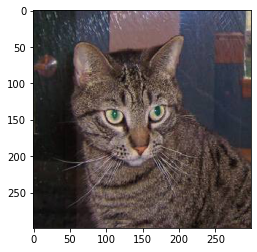

In [ ]:
imshow(np.asarray(images[0]))

## 다른 분류 알고리즘

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', gamma='auto')
clf.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
clf.score(X_test, y_test)

0.9825

In [ ]:
from sklearn import svm
clf1 = svm.SVC(kernel='poly', gamma='auto')
clf1.fit(X_train, y_train)

SVC(gamma='auto', kernel='poly')

In [ ]:
clf1.score(X_test, y_test)

0.8725

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(max_depth=2, n_estimators=1000)

In [ ]:
xgb_model.fit(X_train, y_train)

C:\Users\Sang\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
xgb_model.score(X_test, y_test)

0.9875

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(max_depth = 2, n_estimators = 100)

In [ ]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2)

In [ ]:
gb.score(X_test, y_test)

0.98